<a href="https://colab.research.google.com/github/lee-seong-wook/Multiclass_Classification/blob/main/Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#zip 파일 압축
import zipfile

zip_path = '/content/drive/MyDrive/imagedata (1).zip'
target_folder = '/content/drive/MyDrive'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)


In [ ]:

dir_ = Path('/content/drive/MyDrive/data/natural_images')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(8)

,Filepath,Label
0,/content/drive/MyDrive/data/natural_images/per...,person
1,/content/drive/MyDrive/data/natural_images/dog...,dog
2,/content/drive/MyDrive/data/natural_images/cat...,cat
3,/content/drive/MyDrive/data/natural_images/fru...,fruit
4,/content/drive/MyDrive/data/natural_images/dog...,dog
5,/content/drive/MyDrive/data/natural_images/fru...,fruit
6,/content/drive/MyDrive/data/natural_images/dog...,dog
7,/content/drive/MyDrive/data/natural_images/mot...,motorbike


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 6899

Number of different labels: 8

Labels: ['person' 'dog' 'cat' 'fruit' 'motorbike' 'airplane' 'car' 'flower']


In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((6209, 2), (690, 2))

In [ ]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/data/natural_images',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/data/natural_images',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


In [ ]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=8, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])
cnn.summary()

In [ ]:
#모델 레이어 시각화 jpg ,png, jpeg 상관없음
from tensorflow.keras.utils import plot_model
plot_model(cnn, to_file='model_plot.jpeg', show_shapes=True, show_layer_names=True)

In [ ]:
history = cnn.fit(x = train_gen, validation_data = val_gen, epochs = 5)

Epoch 1/5
173/173 [==============================] - 22s 116ms/step - loss: 0.8858 - accuracy: 0.7251 - val_loss: 0.3530 - val_accuracy: 0.8838
Epoch 2/5
173/173 [==============================] - 20s 113ms/step - loss: 0.2562 - accuracy: 0.9044 - val_loss: 0.3320 - val_accuracy: 0.8686
Epoch 3/5
173/173 [==============================] - 20s 114ms/step - loss: 0.1429 - accuracy: 0.9466 - val_loss: 0.2453 - val_accuracy: 0.9136
Epoch 4/5
173/173 [==============================] - 20s 114ms/step - loss: 0.0764 - accuracy: 0.9730 - val_loss: 0.3799 - val_accuracy: 0.8831
Epoch 5/5
173/173 [==============================] - 19s 112ms/step - loss: 0.0463 - accuracy: 0.9846 - val_loss: 0.4021 - val_accuracy: 0.8780


In [ ]:
# 학습 과정의 손실과 정확도 데이터 가져오기
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드

    # 학습 데이터 생성기
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2  # 데이터를 학습과 검증 데이터로 분할하는 비율
    )

    # 테스트 데이터 생성기
    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    # 학습 데이터 로드
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,  # 학습 데이터가 있는 데이터프레임
        x_col='Filepath',  # 이미지 파일 경로 열의 이름
        y_col='Label',  # 클래스 레이블 열의 이름
        target_size=(224, 224),  # 이미지 크기
        color_mode='rgb',  # 이미지 채널 (RGB)
        class_mode='categorical',  # 클래스 모드 (다중 클래스 분류)
        batch_size=32,  # 배치 크기
        shuffle=True,  # 데이터를 섞을지 여부
        seed=0,  # 시드 값
        subset='training',  # 학습 데이터 세트로 사용
        rotation_range=30,  # 이미지 회전 범위
        zoom_range=0.15,  # 이미지 확대/축소 범위
        width_shift_range=0.2,  # 이미지 가로 이동 범위
        height_shift_range=0.2,  # 이미지 세로 이동 범위
        shear_range=0.15,  # 이미지 변형 강도
        horizontal_flip=True,  # 이미지 좌우 반전 여부
        fill_mode="nearest"  # 이미지 변경 시 보완 방법
    )

    # 검증 데이터 로드
    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',  # 검증 데이터 세트로 사용
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    # 테스트 데이터 로드
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False  # 테스트 데이터는 섞지 않음
    )

    return train_generator, test_generator, train_images, val_images, test_images


In [ ]:
models = {
    "DenseNet121": {"model": tf.keras.applications.DenseNet121, "perf": 0},
    "MobileNetV2": {"model": tf.keras.applications.MobileNetV2, "perf": 0},
    "DenseNet201": {"model": tf.keras.applications.DenseNet201, "perf": 0},
    "EfficientNetB0": {"model": tf.keras.applications.EfficientNetB0, "perf": 0},
    #"EfficientNetB1": {"model": tf.keras.applications.EfficientNetB1, "perf": 0},
   # "InceptionV3": {"model": tf.keras.applications.InceptionV3, "perf": 0},
    "MobileNetV3Large": {"model": tf.keras.applications.MobileNetV3Large, "perf": 0},
    "ResNet152V2": {"model": tf.keras.applications.ResNet152V2, "perf": 0},
    "ResNet50": {"model": tf.keras.applications.ResNet50, "perf": 0},
    "ResNet50V2": {"model": tf.keras.applications.ResNet50V2, "perf": 0},
   # "VGG19": {"model": tf.keras.applications.VGG19, "perf": 0},
   # "VGG16": {"model": tf.keras.applications.VGG16, "perf": 0},
   # "Xception": {"model": tf.keras.applications.Xception, "perf": 0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=10,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 4968 validated image filenames belonging to 8 classes.
Found 1241 validated image filenames belonging to 8 classes.
Found 690 validated image filenames belonging to 8 classes.


DenseNet121          trained in 251.55 sec
MobileNetV2          trained in 217.05 sec
DenseNet201          trained in 311.13 sec
EfficientNetB0       trained in 221.93 sec
MobileNetV3Large     trained in 212.45 sec
ResNet152V2          trained in 441.47 sec
ResNet50             trained in 225.24 sec
ResNet50V2           trained in 219.02 sec


In [ ]:
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

22/22 [==============================] - 4s 111ms/step
**DenseNet121 has a 99.86% accuracy on the test set**
22/22 [==============================] - 3s 99ms/step
**MobileNetV2 has a 99.28% accuracy on the test set**
22/22 [==============================] - 6s 145ms/step
**DenseNet201 has a 100.00% accuracy on the test set**
22/22 [==============================] - 4s 117ms/step
**EfficientNetB0 has a 33.91% accuracy on the test set**
22/22 [==============================] - 4s 133ms/step
**MobileNetV3Large has a 83.19% accuracy on the test set**
22/22 [==============================] - 8s 221ms/step
**ResNet152V2 has a 100.00% accuracy on the test set**
22/22 [==============================] - 3s 106ms/step
**ResNet50 has a 85.07% accuracy on the test set**
22/22 [==============================] - 3s 113ms/step
**ResNet50V2 has a 99.86% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.9976,1.0000,311.13
1,ResNet152V2,0.9992,1.0000,441.47
2,DenseNet121,0.9952,0.9986,251.55
3,ResNet50V2,0.9992,0.9986,219.02
4,MobileNetV2,0.9936,0.9928,217.05
5,ResNet50,0.8421,0.8507,225.24
6,MobileNetV3Large,0.8413,0.8319,212.45
7,EfficientNetB0,0.3263,0.3391,221.93


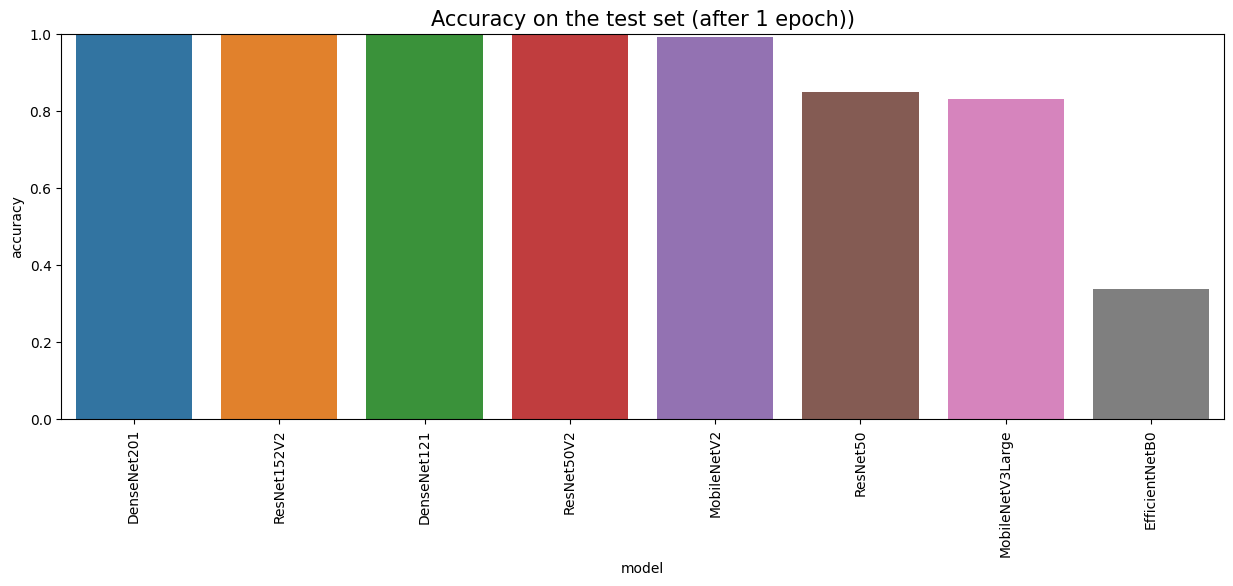

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

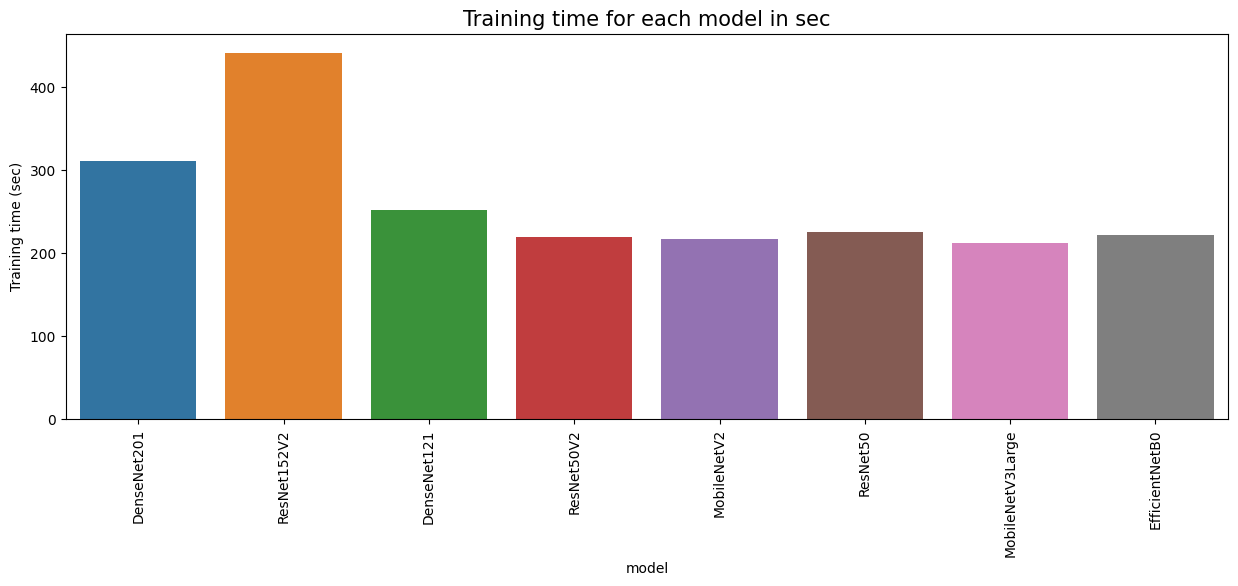

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)
model.save("image classification.h5")

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

22/22 [==============================] - 6s 147ms/step
Accuracy on the test set: 100.00%


In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00        75
         car       1.00      1.00      1.00       117
         cat       1.00      1.00      1.00        71
         dog       1.00      1.00      1.00        74
      flower       1.00      1.00      1.00        75
       fruit       1.00      1.00      1.00       100
   motorbike       1.00      1.00      1.00        84
      person       1.00      1.00      1.00        94

    accuracy                           1.00       690
   macro avg       1.00      1.00      1.00       690
weighted avg       1.00      1.00      1.00       690



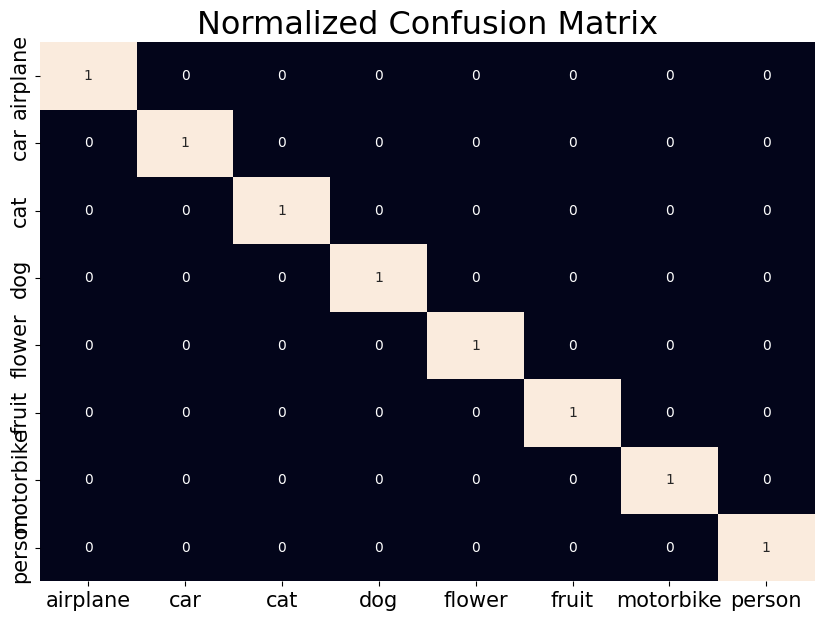

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
#annot true이면 셀마다 숫자 표시 false면 숫자 미표시
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/image classification.h5")

In [ ]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns
    display(Markdown(string))
class_dictionary = {'airplane': 0,
                    'car': 1,
                    'cat': 2,
                    'dog': 3,
                    'flower': 4,
                    'fruit': 5,
                    'motorbike': 6,
                    'person': 7}
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

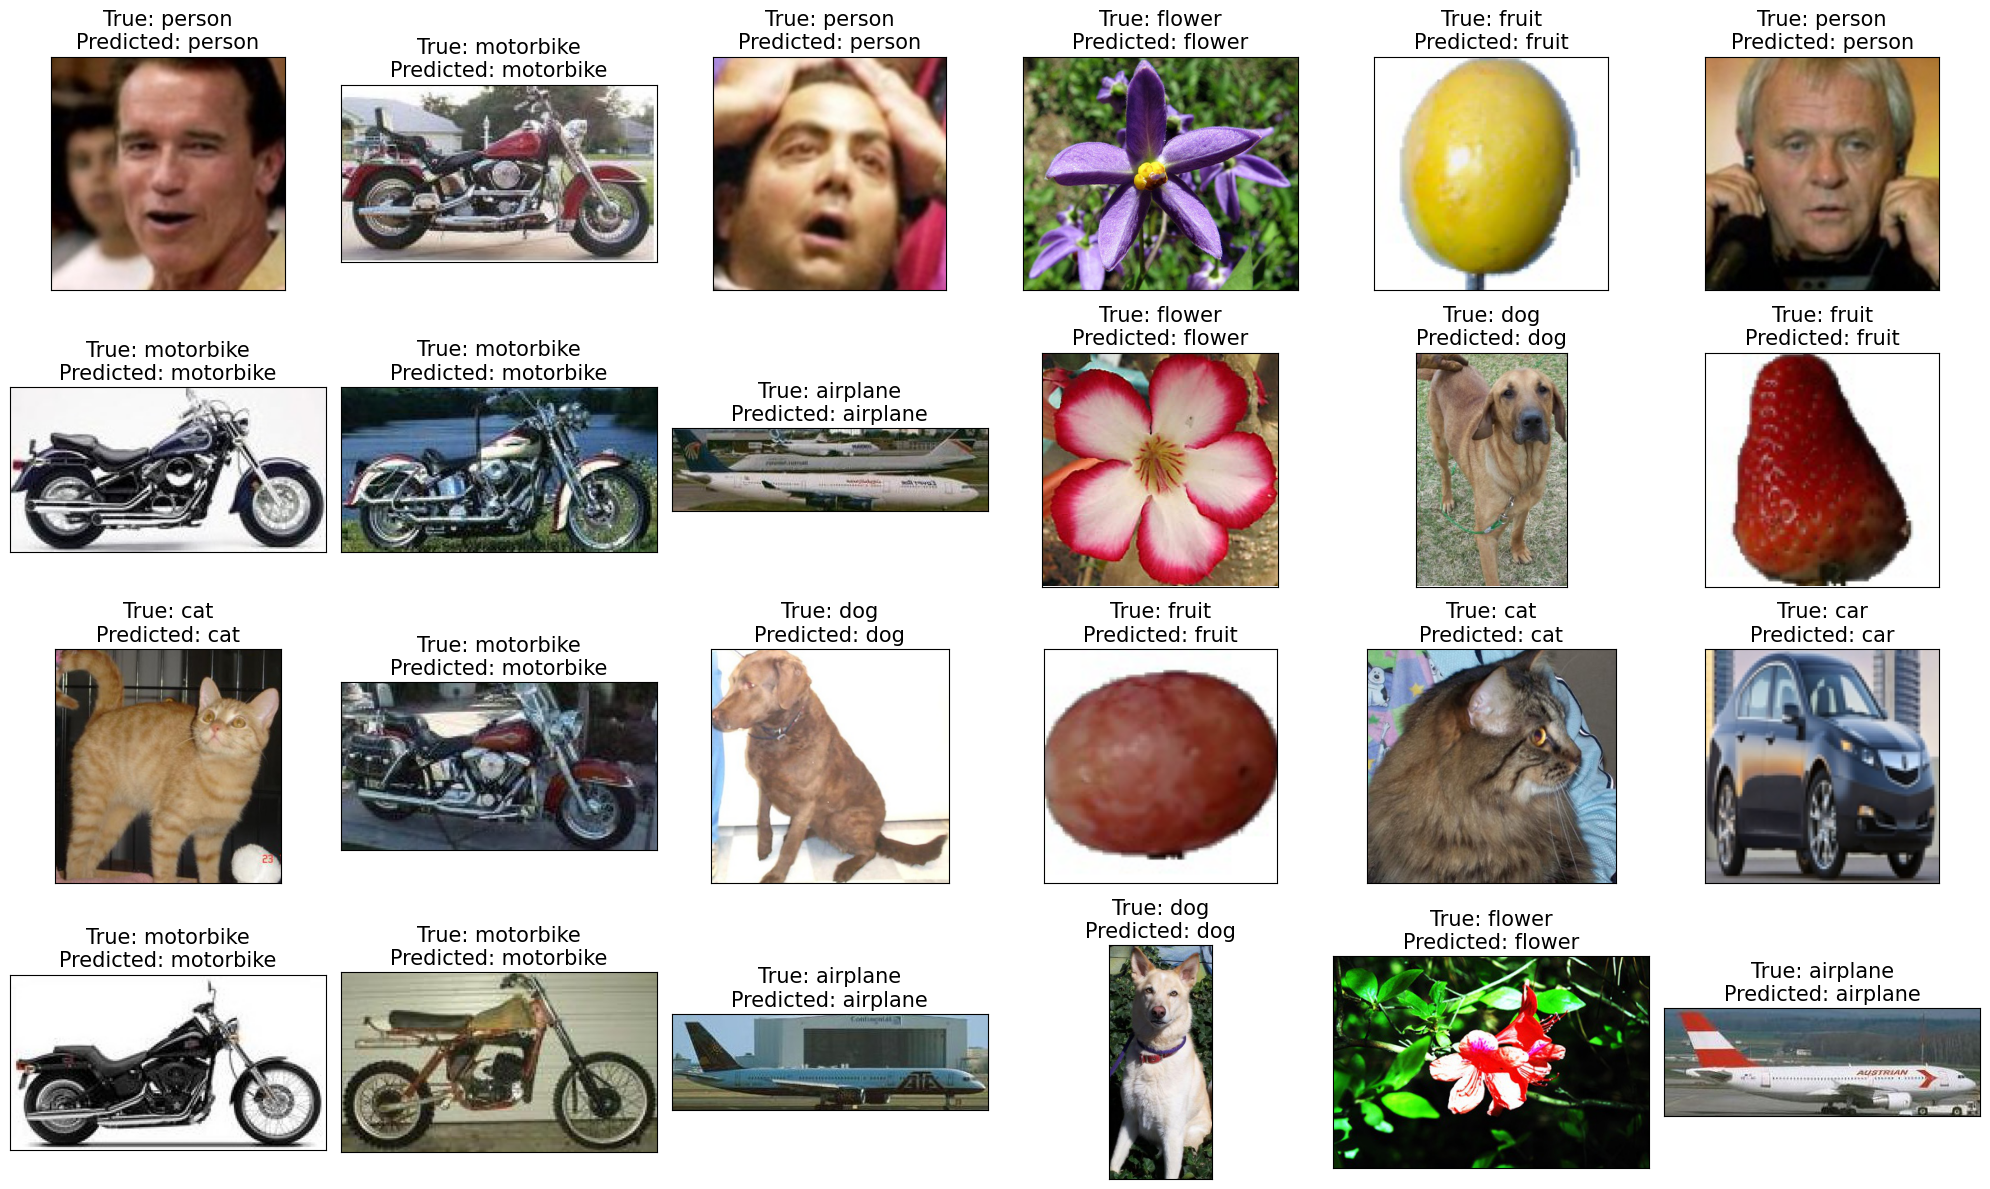

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/image classification.h5")


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

# 모델 로드
loaded_model = load_model('/content/image classification.h5')  # 모델 파일 경로를 올바르게 지정해주세요

# 이미지 전처리 함수
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # 모델 입력 크기에 맞게 이미지 크기 조정
    img = np.array(img) / 255.0  # 이미지 스케일링 (0~1 범위로)
    img = np.expand_dims(img, axis=0)  # 배치 차원 추가
    return img

# 클래스 인덱스와 레이블 매핑
class_names = ["class1", "person", "class3", "class4", "class5", "class6", "class7", "class8"]

# 테스트할 이미지 경로
test_image_path = '/content/drive/MyDrive/data/natural_images/car/car_0000.jpg'  # 테스트하고자 하는 이미지 파일 경로를 올바르게 지정해주세요

# 이미지 전처리
test_image = preprocess_image(test_image_path)

# 모델 예측
predictions = loaded_model.predict(test_image)
predicted_class_index = np.argmax(predictions[0])  # 가장 높은 확률을 가진 클래스 인덱스 선택
predicted_class_label = class_names[predicted_class_index]  # 클래스 레이블로 변환

# 결과 출력
print("Predicted class:", predicted_class_label)
print("Predicted probabilities:", predictions[0])


1/1 [==============================] - 3s 3s/step
Predicted class: person
Predicted probabilities: [1.55980088e-05 9.95187640e-01 1.87410096e-05 1.11610905e-04
 2.75422963e-07 6.30362308e-07 4.59234044e-03 7.31903565e-05]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# 모델 로드
loaded_model = load_model("/content/image classification.h5")  # 모델 파일 경로를 올바르게 지정해주세요

# 테스트 데이터셋 생성
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_images = test_generator.flow_from_directory(
    directory="/content/drive/MyDrive/natural_images",  # 테스트 데이터셋 디렉토리 경로를 올바르게 지정해주세요
    target_size=(224, 224),  # 이미지 크기
    color_mode="rgb",  # 이미지 채널 (RGB)
    class_mode="categorical",  # 클래스 모드 (다중 클래스 분류)
    batch_size=32,  # 배치 크기
    shuffle=False  # 데이터 순서를 섞지 않음
)

# 모델 평가
evaluation = loaded_model.evaluate(test_images, verbose=1)

# 평가 결과 출력
print("Test loss:", evaluation[0])
print("Test accuracy:", evaluation[1])


Found 6899 images belonging to 8 classes.
216/216 [==============================] - 39s 167ms/step - loss: 0.0027 - accuracy: 0.9997
Test loss: 0.0026638724375516176
Test accuracy: 0.9997100830078125
